In [38]:
# Import Libraries
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers

from sklearn import preprocessing

from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.linear_model import LinearRegression

In [27]:
# Data loading
data = pd.read_csv('/content/ISCTR.IS (1).csv', parse_dates=True, index_col=0)

data = data.dropna()

data['High_Low_per'] = (data['High'] - data['Close']) / data['Close'] * 100
data['Per_change'] = (data['Open'] - data['Open']) / data['Close'] * 100
data = data[['Adj Close', 'High_Low_per', 'Per_change', 'Volume']]
label_col = 'Adj Close'

ceil_data = int(math.ceil(0.002*len(data)))
data['label'] = data[label_col].shift(-ceil_data)

X = data.drop(['label'], axis=1).values
X = preprocessing.scale(X)
X = X[:-ceil_data]

# Predict on next days
forecast = X[-ceil_data-7:-ceil_data]

y = data['label'].values

# Drop rows with missing values
data.dropna(inplace=True)

# Convert label column to numpy array
y = data['label'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# **Support Vector Machine**

In [28]:
svr = SVR(kernel='rbf', C=1000, gamma=0.1)
svr.fit(X_train, y_train)

# Predict the test data
prediction_svm = svr.predict(X_test)

# Predict the next 7 days of data
svm_next7days = svr.predict(forecast)

print('Predictions on Test Data:', prediction_svm)
print('Predictions for Next 7 Days:', svm_next7days)

Predictions on Test Data: [ 9.08864093  2.43651402  2.19045425  2.30297279  1.90377403  2.83560405
  3.14955748  1.77343908  2.30075786  1.75806834  2.60063051  3.03103945
  2.13673601  1.67406612  1.69907759  3.0730462   1.74104996  2.16491171
  1.72204408  2.04184396  2.3676724   1.93948575  1.97072397  2.48124705
  7.50389068  2.38497794  3.12008215  2.8426656   2.96815414  2.40136827
  2.40118253  1.80321649  2.26317554  3.12357545  2.67855555  1.7560623
 10.28061396  3.02193346  2.2817801   2.22995894 10.33428124  2.54537617
  1.90648452  2.03317385  2.66396796  1.94674612  2.41437547  2.78546428
  2.95641864  2.32305283  5.31790064  2.86938723  1.66214499  1.86523421
  2.02992267  2.51191023  2.45782394  1.76436752  1.7974778   2.7708949
  2.11752742  2.70647399  2.46679311  1.84805728  2.91645584  9.65461054
 11.27246174  2.45765123  1.79576134  2.18549426 13.36512735  1.92132039
  2.36061536  1.84561245  3.51086753  1.73750631  2.58858901  3.55927827
  2.74071307  1.72293403  1

In [29]:
svm_accuracy = svr.score(X_test, y_test)

print(svm_accuracy*100)

92.70022399165579


# **Linear Regression**

In [30]:
lr = LinearRegression()
lr.fit(X_train, y_train)

lr_prediction = lr.predict(X_test)

# Predict the next 7 days of data
lr_next7days = lr.predict(forecast)

print('Predictions on Test Data:', lr_prediction)
print('Predictions for Next 7 Days:', lr_next7days)

Predictions on Test Data: [ 8.10070926  2.45491499  2.23745404  2.4027465   1.92866314  2.86775342
  3.18656496  1.7626832   2.30666423  1.71241734  2.59789536  3.04191809
  2.14088071  1.63982202  1.69453996  3.08561541  1.7298374   2.17402148
  1.79095999  2.05468378  2.3717247   1.91273067  1.95213115  2.52406318
  7.75516544  2.35556844  3.16374708  2.8682825   2.98682614  2.35156277
  2.36058083  1.81412251  2.25064578  3.12017832  2.70110694  1.77723578
 10.25445428  3.03089069  2.32403685  2.26160588 10.19458443  2.54411018
  1.92746036  2.03884292  2.6956891   1.93506615  2.41894602  2.78970568
  2.97886724  2.31370108  5.12015077  2.87324543  1.70868937  1.84191978
  2.05173334  2.53095389  2.47164074  1.82459221  1.77543656  2.83549063
  2.12951082  2.73199391  2.49662805  1.82285215  2.95008041 10.67930754
  7.0719273   2.47378642  1.76170507  2.14691301 13.03173509  1.9745812
  2.22399968  2.98910857  3.36206417  1.71707001  2.63963192  3.54588376
  2.77694806  1.77483826  

In [31]:
lr_accuracy = lr.score(X_test, y_test)

print(lr_accuracy*100)

98.00049425157364


# **Deep Neural Network**

In [32]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs = 40, batch_size = 30, validation_data = (X_test, y_test))

Epoch 1/40
55/55 [==============================] - 7s 28ms/step - loss: 6.4032 - val_loss: 1.2059
Epoch 2/40
55/55 [==============================] - 1s 10ms/step - loss: 0.9805 - val_loss: 0.7856
Epoch 3/40
55/55 [==============================] - 1s 11ms/step - loss: 0.7405 - val_loss: 0.6152
Epoch 4/40
55/55 [==============================] - 1s 10ms/step - loss: 0.6115 - val_loss: 0.5335
Epoch 5/40
55/55 [==============================] - 1s 10ms/step - loss: 0.5612 - val_loss: 0.3887
Epoch 6/40
55/55 [==============================] - 1s 11ms/step - loss: 0.4344 - val_loss: 0.2957
Epoch 7/40
55/55 [==============================] - 1s 11ms/step - loss: 0.3973 - val_loss: 0.2503
Epoch 8/40
55/55 [==============================] - 1s 11ms/step - loss: 0.3201 - val_loss: 0.2220
Epoch 9/40
55/55 [==============================] - 1s 11ms/step - loss: 0.3158 - val_loss: 0.2508
Epoch 10/40
55/55 [==============================] - 1s 11ms/step - loss: 0.2847 - val_loss: 0.1981
Epoch 11/

In [33]:
dnn_prediction = model.predict(X_test)

# Predict for the next 7 days data
dnn_next7days = model.predict(forecast)

print('Predictions on Test Data:', dnn_prediction)
print('Predictions for Next 7 Days:', dnn_next7days)

1/1 [==============================] - 0s 20ms/step
Predictions on Test Data: [[ 9.625164 ]
 [ 2.4326394]
 [ 2.0630033]
 [ 2.1891713]
 [ 1.7027862]
 [ 2.9629385]
 [ 3.5027385]
 [ 1.623557 ]
 [ 2.2861323]
 [ 2.0131261]
 [ 2.5190666]
 [ 2.9339721]
 [ 2.097579 ]
 [ 1.8874253]
 [ 1.4994675]
 [ 3.0702512]
 [ 1.7514501]
 [ 2.107664 ]
 [ 1.6010641]
 [ 2.3378403]
 [ 2.5825007]
 [ 1.9267163]
 [ 2.3689845]
 [ 2.4243467]
 [ 9.424867 ]
 [ 2.2498467]
 [ 3.3698778]
 [ 2.8186703]
 [ 2.8371072]
 [ 2.6049342]
 [ 2.2875426]
 [ 1.7352155]
 [ 2.36793  ]
 [ 2.9861505]
 [ 2.8382964]
 [ 1.9033917]
 [10.75789  ]
 [ 2.8803046]
 [ 2.082333 ]
 [ 2.085682 ]
 [10.758611 ]
 [ 2.5105956]
 [ 1.7861942]
 [ 1.9871812]
 [ 2.6625943]
 [ 1.8900447]
 [ 2.581697 ]
 [ 2.612563 ]
 [ 2.9756057]
 [ 2.229566 ]
 [ 5.782797 ]
 [ 2.7492075]
 [ 1.6432911]
 [ 1.7845081]
 [ 1.9117341]
 [ 2.553939 ]
 [ 2.512279 ]
 [ 1.6602762]
 [ 1.9439394]
 [ 2.6800199]
 [ 2.0416796]
 [ 2.9296725]
 [ 2.319062 ]
 [ 1.9090831]
 [ 2.9721522]
 [10.859985 

# **Visualization**

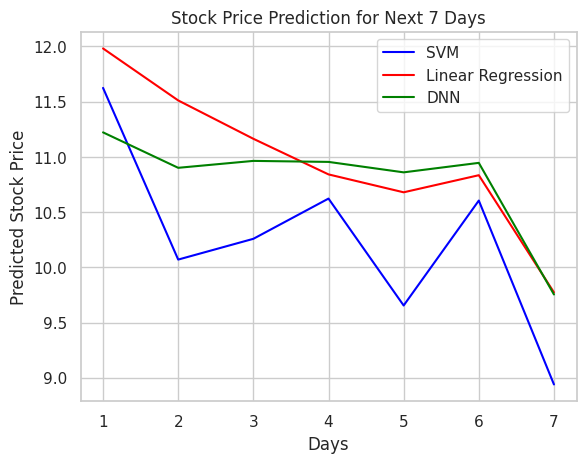

In [34]:
# Visualizing the comparision of the days

# Create a list of days
days = [1, 2, 3, 4, 5, 6, 7]

# Plot the data
plt.plot(days, svm_next7days, color='blue', label='SVM')
plt.plot(days, lr_next7days, color='red', label='Linear Regression')
plt.plot(days, dnn_next7days, color='green', label='DNN')

# Add labels and title
plt.xlabel('Days')
plt.ylabel('Predicted Stock Price')
plt.title('Stock Price Prediction for Next 7 Days')

# Add legend
plt.legend()

# Show the plot
plt.show()


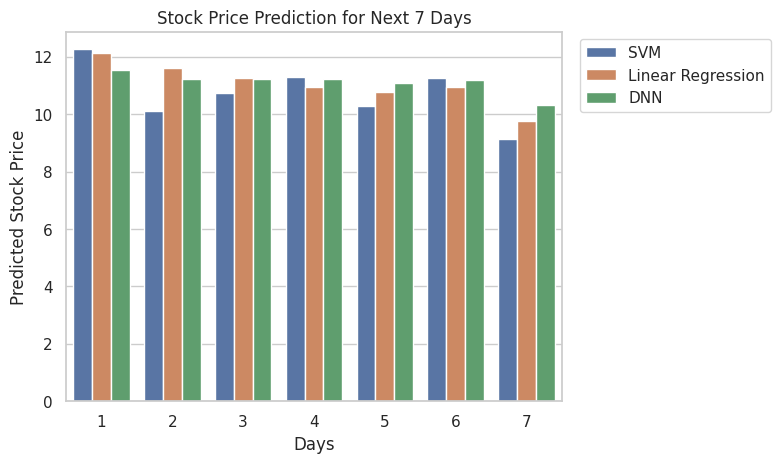

In [36]:
# Define the predicted values for SVM, Linear Regression, and DNN
svm_next7days = [12.25693225, 10.1123252, 10.7488707, 11.30425637, 10.27959834, 11.24091329, 9.13999752]
lr_next7days = [12.11145881, 11.59601589, 11.26758707, 10.94751006, 10.76198022, 10.94537396, 9.76628752]
dnn_next7days = [11.5351515, 11.206194, 11.2260275, 11.203941, 11.088118, 11.192676, 10.310493]

# Create a pandas dataframe with the predicted values
data = {'Days': [1, 2, 3, 4, 5, 6, 7],
        'SVM': svm_next7days,
        'Linear Regression': lr_next7days,
        'DNN': dnn_next7days}

df = pd.DataFrame(data)

# Reshape the data to create a "long" format for the barplot
df = df.melt(id_vars=['Days'], var_name='Algorithm', value_name='Predicted Stock Price')

# Create the barplot using Seaborn
sns.set(style="whitegrid")
ax = sns.barplot(x='Days', y='Predicted Stock Price', hue='Algorithm', data=df)

# Adjust the position of the legend
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# Add a title
ax.set_title('Stock Price Prediction for Next 7 Days')

# Show the plot
plt.show()